100%|██████████| 50/50 [13:32<00:00, 16.24s/it]


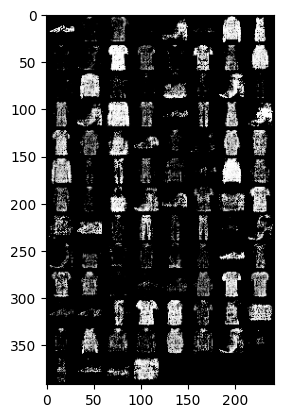

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import tqdm
import os
import subprocess
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import numpy as np
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batchsize = 100

# Fashion MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.FashionMNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True)

denormalize = transforms.Compose([
    transforms.Normalize(0., 1. / .5),
    transforms.Normalize(-.5, 1.)
])

# Generator and Discriminator classes
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features * 2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features * 2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features // 2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features // 2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

z_dim = 100
fmnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim=z_dim, g_output_dim=fmnist_dim).to(device)
D = Discriminator(fmnist_dim).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

def D_train(x):
    D.zero_grad()


    x_real, y_real = x.view(-1, fmnist_dim), torch.ones(batchsize, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output


    z = Variable(torch.randn(batchsize, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(batchsize, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return D_loss.data.item()

def G_train(x):
    G.zero_grad()

    z = Variable(torch.randn(batchsize, z_dim).to(device))
    y = Variable(torch.ones(batchsize, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)


    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

n_epoch = 50

for epoch in tqdm.tqdm(range(n_epoch)):
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

# Create a directory to save the output
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)

# Save the Generator model
torch.save(G.state_dict(), os.path.join(output_dir, 'generator_model.pth'))


with torch.no_grad():
    test_z = Variable(torch.randn(batchsize, z_dim).to(device))
    generated = G(test_z)
    save_image(generated.view(generated.size(0), 1, 28, 28), os.path.join(output_dir, 'sample_60_epochs.png'))


image = mpimg.imread(os.path.join(output_dir, 'sample_60_epochs.png'))
plt.imshow(image)
plt.show()


Epoch [0/50], Step [0/938], D Loss: 1.3946, G Loss: 0.6952
Epoch [0/50], Step [300/938], D Loss: 0.2793, G Loss: 4.5114
Epoch [0/50], Step [600/938], D Loss: 0.4933, G Loss: 3.1217
Epoch [0/50], Step [900/938], D Loss: 0.5223, G Loss: 5.9885
Epoch [1/50], Step [0/938], D Loss: 0.6258, G Loss: 3.1544
Epoch [1/50], Step [300/938], D Loss: 0.8167, G Loss: 2.8049
Epoch [1/50], Step [600/938], D Loss: 0.4466, G Loss: 2.8393
Epoch [1/50], Step [900/938], D Loss: 0.7299, G Loss: 3.2088
Epoch [2/50], Step [0/938], D Loss: 0.2902, G Loss: 3.3956
Epoch [2/50], Step [300/938], D Loss: 0.1982, G Loss: 3.8335
Epoch [2/50], Step [600/938], D Loss: 0.4522, G Loss: 2.9916
Epoch [2/50], Step [900/938], D Loss: 0.5419, G Loss: 2.9764
Epoch [3/50], Step [0/938], D Loss: 0.5563, G Loss: 3.2211
Epoch [3/50], Step [300/938], D Loss: 0.4694, G Loss: 2.0633
Epoch [3/50], Step [600/938], D Loss: 0.6589, G Loss: 2.5213
Epoch [3/50], Step [900/938], D Loss: 0.6768, G Loss: 2.3653
Epoch [4/50], Step [0/938], D Lo

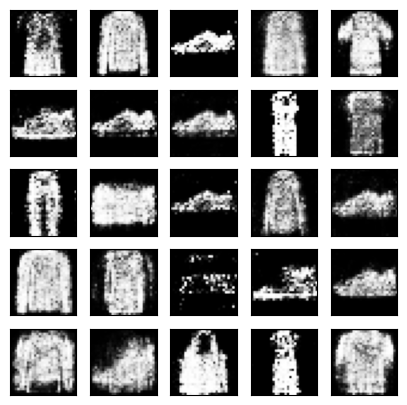

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import numpy as np

# Set your device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
batch_size = 64
z_dim = 100
fmnist_dim = 28 * 28
lr = 0.0002
n_epochs = 50

# Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
train_dataset = datasets.FashionMNIST(root='./mnist_data/', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features * 2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features * 2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features // 2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features // 2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

# Create generator and discriminator
G = Generator(g_input_dim=z_dim, g_output_dim=fmnist_dim).to(device)
D = Discriminator(d_input_dim=fmnist_dim).to(device)

# Loss and optimizers
criterion = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)

# Training the GAN
def D_train(x, batch_size):
    D.zero_grad()

    # Train discriminator on real
    x_real, y_real = x.view(-1, fmnist_dim), torch.ones(batch_size, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # Train discriminator on fake
    z = Variable(torch.randn(batch_size, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(batch_size, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # Gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return D_loss.data.item()


def G_train(x):
    G.zero_grad()

    z = Variable(torch.randn(batch_size, z_dim).to(device))
    y = Variable(torch.ones(batch_size, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # Gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

# Training loop
for epoch in range(50):
    for i, (images, _) in enumerate(data_loader):
        batch_size = images.size(0)  # Get the current batch size

        real_images = Variable(images).to(device)

        # Train discriminator
        D_loss = D_train(real_images, batch_size)

        # Train generator
        G_loss = G_train(batch_size)

        # Print and log the losses, and update the generator
        if i % display_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], D Loss: {:.4f}, G Loss: {:.4f}'
                  .format(epoch, num_epochs, i, len(data_loader), D_loss, G_loss))



sample_size = 25
z = Variable(torch.randn(sample_size, z_dim).to(device))
samples = G(z).data.cpu().numpy()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5, 5), sharey=True, sharex=True)

for ax, sample in zip(axes.flatten(), samples):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(sample.reshape((28, 28)), cmap="Greys_r")

plt.show()
